### Gekko Optimization Under Uncertainty with GPR

This notebook demonstrates how to use the Gekko package in Python for optimization with a Gaussian Process Regression (GPR) model. It effectively combines machine learning (GPR) with optimization (Gekko), showcasing how Gekko can be used to optimize variables based on predictions and uncertainty from a machine learning model. See [Engineering Optimization course website](https://apmonitor.com/me575) for additional information on [Optimization Under Uncertainty](https://apmonitor.com/me575/index.php/Main/GPROptimization). Example problem generated by [LaGrande Gunnell](https://www.linkedin.com/in/lagrande-gunnell-715a2b194/).

<img src='https://apmonitor.com/me575/uploads/Main/optimize_uncertainty.png' align=left width=600px>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.gaussian_process as gp
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

try:
  from gekko.ML import Gekko_GPR
  from gekko import GEKKO
except:
  !pip install gekko
  from gekko.ML import Gekko_GPR
  from gekko import GEKKO

**Data Generation and Visualization**: Define a function to generate data with noise and visualizes this data along with the true function.

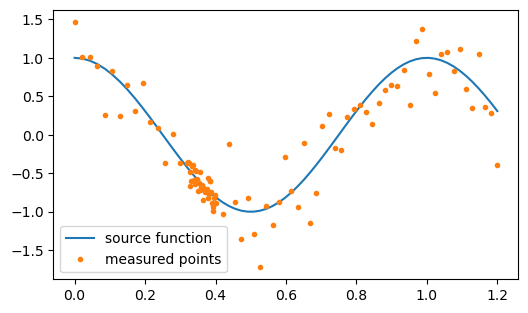

In [2]:
#Source function to generate data
def f(x):
    return np.cos(2*np.pi*x)

#represent noise from a data sample
N = 150
p1 = np.linspace(0.00,0.3,15)
p2 = np.linspace(0.32,0.4,40)
p3 = np.linspace(0.42,1.2,45)
xl = np.concatenate((p1,p2,p3))
np.random.seed(14)
n1 = np.random.normal(0,0.3,15)
n2 = np.random.normal(0,0.1,40)
n3 = np.random.normal(0,0.3,45)
noise = np.concatenate((n1,n2,n3))
y_measured = f(xl) + noise

plt.figure(figsize=(6,3.5))
plt.plot(xl,f(xl),label='source function')
plt.plot(xl,y_measured,'.',label='measured points')
plt.legend()
plt.show()

**Data Preparation**: Data is split into training and testing sets using `train_test_split` from `scikit-learn`.

In [3]:
data = pd.DataFrame(np.array([xl,y_measured]).T,columns=['x','y'])
features = ['x']
label = ['y']

train,test = train_test_split(data,test_size=0.2,shuffle=True)

**GPR Model Training**: A Gaussian Process Regressor (GPR) is created and trained on the training data. The performance of the model is evaluated using the R-squared metric on the test data.

In [4]:
k = gp.kernels.RBF() * gp.kernels.ConstantKernel() + gp.kernels.WhiteKernel()
gpr = gp.GaussianProcessRegressor(kernel=k,\
                            n_restarts_optimizer=10,\
                            alpha=0.1,\
                            normalize_y=True)
gpr.fit(train[features],train[label])
r2 = gpr.score(test[features],test[label])
print('gpr r2:',r2)

gpr r2: 0.8864050549567807


**Model Visualization**: The trained GPR model predictions and confidence intervals are plotted against the true function and noisy measurements.

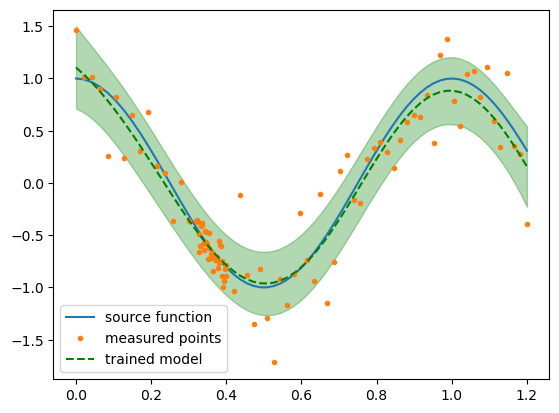

In [5]:
prediction_data = pd.DataFrame(np.array([xl]).T, columns=features)
model_pred, model_std = gpr.predict(prediction_data, return_std=True)

t = 1.96 #2 sided 90% Confidence interval z-infinity score

plt.plot(xl,f(xl),label='source function')
plt.plot(xl,y_measured,'.',label='measured points')
plt.plot(xl,model_pred,'--',label='trained model',color='green')
plt.fill_between(xl,model_pred-t*model_std,model_pred+t*model_std,alpha=0.3,color='green')
plt.legend()
plt.show()

**Optimization with Gekko**: The Gekko package is used to perform optimization. A variable is created within Gekko and the trained GPR model is used to predict the output and its uncertainty for this variable. Gekko then optimizes this variable to minimize the objective, which in this case is either the predicted value or the uncertainty of the prediction.

In [6]:
m = GEKKO(remote=False)
x = m.Var(0,lb=0,ub=1)
y,y_std = Gekko_GPR(gpr,m).predict(x,return_std=True)
m.Minimize(y)
m.solve(disp=False)
print('solution:',y.value[0],'std:',y_std.value[0])
print('x:',x.value[0])
print('Gekko Solvetime:',m.options.SOLVETIME,'s')

opt_val = [x.value[0],y.value[0]]

solution: -0.96252603348 std: 0.15472887792
x: 0.50392284306
Gekko Solvetime: 0.1255 s


**Uncertainty Optimization**: uncertainty is minimized.

In [7]:
m = GEKKO(remote=False)
x = m.Var(0,lb=0,ub=1)
y,y_std = Gekko_GPR(gpr,m).predict(x,return_std=True)
m.Minimize(y_std)
m.solve(disp=False)
print('solution:',y.value[0],'std:',y_std.value[0])
print('x:',x.value[0])
print('Gekko Solvetime:',m.options.SOLVETIME,'s')

opt_val2 = [x.value[0],y.value[0],y_std.value[0]]

solution: -0.66002551977 std: 0.14635915618
x: 0.36558555878
Gekko Solvetime: 0.1396 s


**Multi-Objective Uncertainty Optimization**: uncertainty and expected values are minimized as a weighted sum.

In [8]:
m = GEKKO(remote=False)
x = m.Var(0,lb=0,ub=1)
y,y_std = Gekko_GPR(gpr,m).predict(x,return_std=True)
m.Minimize(y+50*y_std)
m.solve(disp=False)
print('solution:',y.value[0],'std:',y_std.value[0])
print('x:',x.value[0])
print('Gekko Solvetime:',m.options.SOLVETIME,'s')

opt_val3 = [x.value[0],y.value[0],y_std.value[0]]

solution: -0.82902984952 std: 0.14784388837
x: 0.41396832055
Gekko Solvetime: 0.1775 s


**Results Visualization**: Finally, the optimization results are visualized, showing the points of optimized predicted values and uncertainties.

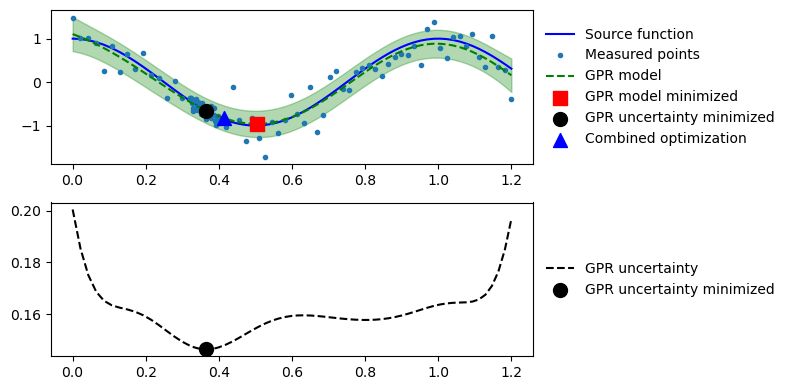

In [9]:
model_pred, model_std = gpr.predict(prediction_data, return_std=True)

t = 1.96 #2 sided 90% Confidence interval z-infinity score
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(xl,f(xl),'b-',label='Source function')
plt.plot(xl,y_measured,'.',label='Measured points')
plt.plot(xl,model_pred,'--',label='GPR model',color='green')
plt.fill_between(xl,model_pred-t*model_std,model_pred+t*model_std,alpha=0.3,color='green')
plt.scatter([opt_val[0]],[opt_val[1]],label='GPR model minimized',color='red',marker='s',s=100,zorder=3)
plt.scatter([opt_val2[0]],[opt_val2[1]],label='GPR uncertainty minimized',color='black',marker='o',s=100,zorder=3)
plt.scatter([opt_val3[0]],[opt_val3[1]],label='Combined optimization',color='blue',marker='^',s=100,zorder=3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=10,frameon=False)
plt.subplot(2,1,2)
plt.plot(xl,model_std,'k--',label='GPR uncertainty')
plt.scatter([opt_val2[0]],[opt_val2[2]],label='GPR uncertainty minimized',color='black',marker='o',s=100,zorder=3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=10,frameon=False)
plt.tight_layout()
plt.show()